# Regularized Linear Regression

In this notebook we use a regularized version of the linear regression model on a non-linear representation of our input space. If that sounds a bit confusing, please make sure you have gone through `notebook_01`and `notebook_02`. Here we only share the following key insights:
- To make a non-linear regression model we just use a non-linear funtion to transform our input $\mathbf{x}$ into $\phi({x})$. In the previous notebook we used a polynomial function.
- If you use non-linear models your model has higher capacity and may overfit your training data.
- When you are overfitting the weights of your model get bigger.

In particular, we will use a Ridge Regression model, here are some things you need to keep in mind so that your implementation works correctly:

- Predictions: $\hat{Y} = X \mathbf{w}$
- Loss function: $\| Y - X \mathbf{w} \| _{2}^{2} + \lambda \| w \|_{2}^{2}$
- Solution by normal equations: $ \mathbf{w} = (X^{T}X  + \lambda I)^{-1} X^{T}Y$
- Gradient of the loss: $\nabla{L} = -\mathbb{1}X^{T}(Y - \hat{Y}) + \lambda\mathbf{w}$

Here are some references where you can review the Ridge Regression:

- [Bias vs Variance lecture on Andrew Ng's Coursera Course](https://www.coursera.org/learn/machine-learning/lecture/4VDlf/regularization-and-bias-variance).
- [Lecture 9 from CS229](https://www.youtube.com/watch?v=tojaGtMPo5U&list=PLA89DCFA6ADACE599&index=9).
- [Chapter 3 of The Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/).
- [Chapter 3 from Pattern Recognition and Machine Learning](https://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738).

## Setup

In [28]:
import sys
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
sys.path.append('..')
import utils

In [30]:
import lib
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
def polynomial_features(X, degree=2):
    X_ = preprocessing.PolynomialFeatures(
            degree=degree, include_bias=False).fit_transform(X.copy())
    return X_

In [32]:
X_train, y_train, X_test, y_test = utils.load_toy_dataset('../toy_datasets/regression/data.csv', ['X'])

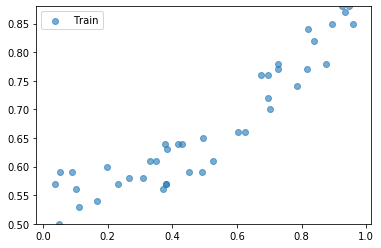

In [33]:
utils.plot_univariate_regression(X_train, y_train)

## Validate implementation

**Validate loss**

In [41]:
value = lib.l2_regularized_mean_squared_error(np.array([1,2]), np.array([3,5]), np.array([[7], [13]]), 0)
assert value == 6.5
value = lib.l2_regularized_mean_squared_error(np.array([1,2]), np.array([3,5]), np.array([[0], [0]]), 10)
assert value == 6.5
value1 = lib.l2_regularized_mean_squared_error(np.array([1,2]), np.array([3,5]), np.array([[7], [13]]), 1.5)
value = lib.l2_regularized_mean_squared_error(np.array([1,2]), np.array([3,5]), np.array([[7], [13]]), 0.5)
assert value1 > value
value = lib.l2_regularized_mean_squared_error(np.array([1,2]), np.array([1,2]), np.array([[7], [13]]), 0.5)
assert value > 0.0

**Validate gradient**

In [ ]:
value = lib.mean_squared_error_gradient(np.array([[1,2]]), np.array([[3]]), y_pred=np.array([[3]]))
np.testing.assert_array_equal(value, np.zeros((2,1)))
value = lib.mean_squared_error_gradient(np.array([[0,0]]), np.array([[1]]), y_pred=np.array([[3]]))
np.testing.assert_array_equal(value, np.zeros((2,1)))
value = lib.mean_squared_error_gradient(np.array([[2,7]]), np.array([[1]]), y_pred=np.array([[3]]))
np.testing.assert_array_equal(value, np.array([[4], [14]]))

## Overfitted model

Let us start with what finished in the last notebook: a polynomial model that clearly overfitted the training set

In [20]:
preprocessing_fn = lambda x: polynomial_features(x.copy(), degree=10)

In [21]:
X_train_poly = preprocessing_fn(X_train)
X_test_poly = preprocessing_fn(X_test)

/home/srcolinas/projects/Machine-Learning-Open-Cookbook/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


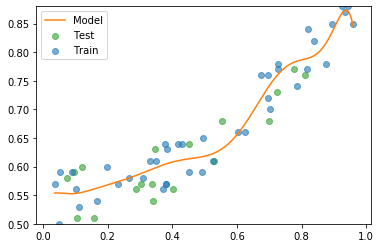

Mean Squared Error on train set: 0.000743
Mean Squared Error on test set: 0.001404
Norm of the weights: 72117.607613
Variance of the weights: 472813575.256622


In [22]:
overfitted_model = lib.LinearRegression()
overfitted_model.fit(X_train_poly, y_train, method='normal equations')

utils.plot_univariate_regression(X_train, y_train, X_test, y_test,
    model_fn = overfitted_model.predict, preprocessing_fn=preprocessing_fn
)

y_pred = overfitted_model.predict(X_train_poly)
mse = lib.mean_squared_error(y_train, y_pred)
print("Mean Squared Error on train set: {:4f}".format(mse))

y_pred = overfitted_model.predict(X_test_poly)
mse = lib.mean_squared_error(y_test, y_pred)
print("Mean Squared Error on test set: {:4f}".format(mse))

print("Norm of the weights: {:4f}".format(np.linalg.norm(overfitted_model.coef)))
print("Variance of the weights: {:4f}".format(np.var(overfitted_model.coef)))

In [23]:
overfitted_model.coef

array([[ 5.35697013e-01],
       [ 1.27077913e+00],
       [-3.27904129e+01],
       [ 4.03831543e+02],
       [-2.72208398e+03],
       [ 1.10522080e+04],
       [-2.79957070e+04],
       [ 4.43068242e+04],
       [-4.24055039e+04],
       [ 2.23872559e+04],
       [-4.99538354e+03]])

## Regularized model

Now we make use of our implementation of the regularized linear regression. If we did it correctly we can expect:
- Smaller value of the weights' norm.
- Less *unnatural* curves in the plot of our model.
- Smaller difference between the errors of the train and test set.

Let us define what amount of regularization we need.

In [24]:
reg = 1.0

/home/srcolinas/projects/Machine-Learning-Open-Cookbook/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


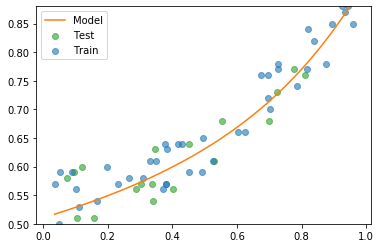

Mean Squared Error on train set: 0.001147
Mean Squared Error on test set: 0.001262
Norm of the weights: 0.552468
Variance of the weights: 0.020654


In [25]:
ridge_model = lib.RidgeRegression(reg=reg)
ridge_model.fit(X_train_poly, y_train, method='normal equations')

utils.plot_univariate_regression(X_train, y_train, X_test, y_test,
    model_fn = ridge_model.predict, preprocessing_fn=preprocessing_fn
)

y_pred = ridge_model.predict(X_train_poly)
mse = lib.mean_squared_error(y_train, y_pred)
print("Mean Squared Error on train set: {:4f}".format(mse))

y_pred = ridge_model.predict(X_test_poly)
mse = lib.mean_squared_error(y_test, y_pred)
print("Mean Squared Error on test set: {:4f}".format(mse))

print("Norm of the weights: {:4f}".format(np.linalg.norm(ridge_model.coef)))
print("Variance of the weights: {:4f}".format(np.var(ridge_model.coef)))

We did it! Let us test it now with our implementation of the grandient descent method

/home/srcolinas/projects/Machine-Learning-Open-Cookbook/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


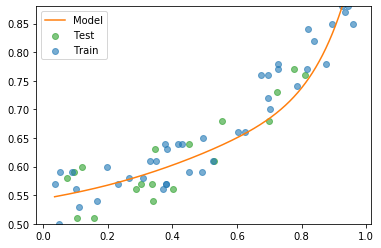

Mean Squared Error on train set: 0.001676
Mean Squared Error on test set: 0.001246
Norm of the weights: 0.947793
Variance of the weights: 0.072492


In [26]:
ridge_model = lib.RidgeRegression(reg=reg)
ridge_model.fit(X_train_poly, y_train, method='gradient descent', num_iterations=700)

utils.plot_univariate_regression(X_train, y_train, X_test, y_test,
    model_fn = ridge_model.predict, preprocessing_fn=preprocessing_fn
)

y_pred = ridge_model.predict(X_train_poly)
mse = lib.mean_squared_error(y_train, y_pred)
print("Mean Squared Error on train set: {:4f}".format(mse))

y_pred = ridge_model.predict(X_test_poly)
mse = lib.mean_squared_error(y_test, y_pred)
print("Mean Squared Error on test set: {:4f}".format(mse))

print("Norm of the weights: {:4f}".format(np.linalg.norm(ridge_model.coef)))
print("Variance of the weights: {:4f}".format(np.var(ridge_model.coef)))

## Final notes

Consider the following:
- We did not say you would get better model performance! Consider the ridge regression as a tool that may or may not help you improve performance.
- Plot the learning curves to debug your implementation of gradient descent! While developing this notebook and implementation there was a bug that was resolved only until we ploted the learning curves :)